In [15]:
from google.colab import files
uploaded = files.upload()

Saving yalefaces.zip to yalefaces.zip


In [16]:
!unzip yalefaces.zip

Archive:  yalefaces.zip
   creating: yalefaces/
   creating: yalefaces/person-4/
  inflating: yalefaces/person-4/rightlight  
  inflating: yalefaces/person-4/leftlight  
  inflating: yalefaces/person-4/normal  
  inflating: yalefaces/person-4/noglasses  
  inflating: yalefaces/person-4/happy  
  inflating: yalefaces/person-4/centerlight  
  inflating: yalefaces/person-4/sleepy  
  inflating: yalefaces/person-4/glasses  
  inflating: yalefaces/person-4/wink  
  inflating: yalefaces/person-4/surprised  
   creating: yalefaces/person-15/
  inflating: yalefaces/person-15/rightlight  
  inflating: yalefaces/person-15/leftlight  
  inflating: yalefaces/person-15/normal  
  inflating: yalefaces/person-15/noglasses  
  inflating: yalefaces/person-15/sad  
  inflating: yalefaces/person-15/centerlight  
  inflating: yalefaces/person-15/sleepy  
  inflating: yalefaces/person-15/glasses  
  inflating: yalefaces/person-15/wink  
  inflating: yalefaces/person-15/surprised  
   creating: yalefaces/pe

In [19]:
!pip install scikit_image
import pandas as pd
import numpy as np
import random
import os
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

### Face Detection using PCA

Using PCA mechanism to correctly assign the face images to persons on the [Yale Face Dataset](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/). Download the training data and testing data in this link.
#### Assignment 1 (4 scores): Implement PCA using Numpy.
#### Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.
#### Assignment 3 (2 scores):
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

In [93]:
BASE_DIR='yalefaces'
person_folders = [f'person-{i}' for i in range(1, 16)]

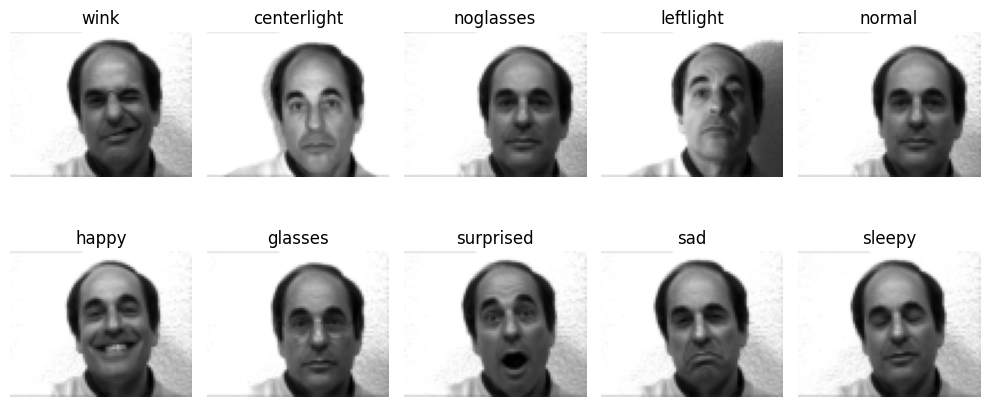

In [74]:
person_folder = random.choice(person_folders)
plt.figure(figsize=(10, 5))
for ith, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
  image = imread(os.path.join(BASE_DIR, person_folder, filename))
  image = image.squeeze(0)
  image = resize(image, (64, 80), anti_aliasing=True)
  plt.subplot(2, 5, ith+1)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.title(filename)
plt.tight_layout()
plt.show()

In [160]:
data = {}
for person_folder in person_folders:
  for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    if person_folder not in data:
      data[person_folder] = [image]
    else:
      data[person_folder].append(image)
for person in data:
  data[person] = np.concat(data[person], axis=0).reshape(10, -1)

In [153]:
data['person-1'].shape

(10, 5120)

Standardizing Images

In [187]:
def standardizing(images: np.ndarray, mean=None, std=None) -> np.ndarray:
    if mean is None:
        mean = images.mean()
    if std is None:
        std = images.std()
    images = (images - mean) / std
    return images.astype(np.float32)

Principle Components Analysis

In [188]:
class PrincipleComponentAnalysis:
    def __init__(self, d_principle: int = 1):
        self.d_principle = d_principle

    def fit(self, X: np.ndarray):
        cov = X.T @ X
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]
        eigenvectors = eigenvectors.T

        eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i, :]) for i in range(eigenvectors.shape[0])]
        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)

        eigenvalues = np.array([value for (value, _) in eigen_pairs])
        eigenvectors = np.array([vector for (_, vector) in eigen_pairs])

        self._principle_values = eigenvalues[:self.d_principle]
        self._W = eigenvectors[:self.d_principle]

    def transform(self, X: np.ndarray) -> np.ndarray:
        return self._W @ X

Finding the Principle Components

In [218]:
PCA = PrincipleComponentAnalysis(d_principle=20)
images = []
for person in data:
  images.append(data[person])

images = np.concat(images, axis = 0)
images = standardizing(images)
images.shape

(150, 5120)

In [219]:
mean_image = images.mean(axis=0)
images_centered = images - mean_image

In [220]:
PCA.fit(images_centered)

In [221]:
PCA._W.shape

(20, 5120)

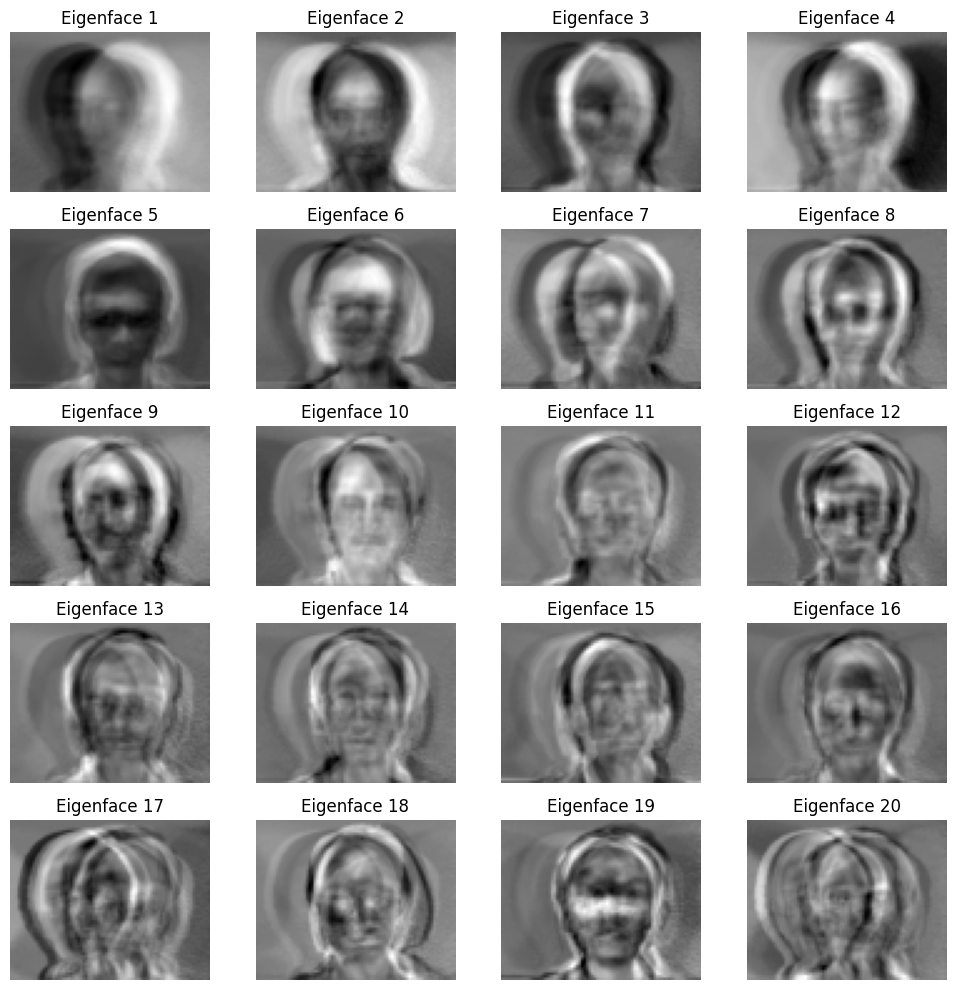

In [222]:
eigenfaces = PCA._W.reshape(20, 64, 80)
plt.figure(figsize=(10, 10))
for ith, eigenface in enumerate(eigenfaces):
    plt.subplot(5, 4, ith+1)
    plt.imshow(np.real(eigenface), cmap='gray')
    plt.axis('off')
    plt.title(f'Eigenface {ith+1}')
plt.tight_layout()
plt.show()

Finding meanfaces

In [223]:
mean_faces = {
    person: np.mean(images, axis=0) for person, images in data.items()
}

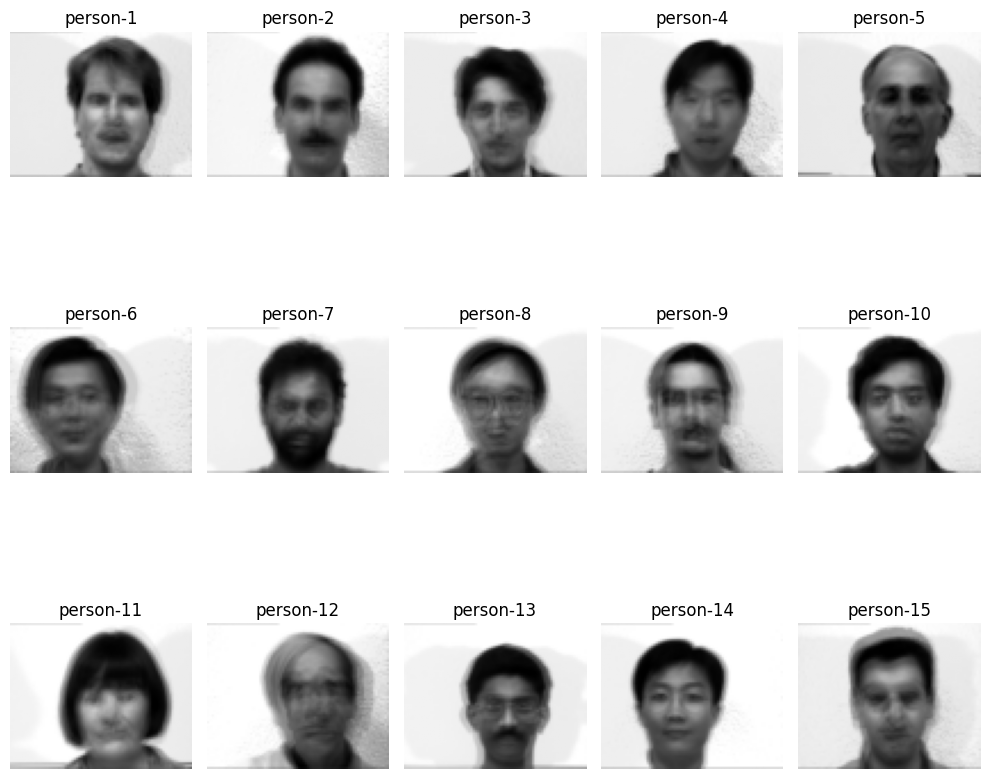

In [224]:
plt.figure(figsize=(10, 10))
for ith, person in enumerate(mean_faces):
  mean_face = mean_faces[person]
  mean_face = mean_face.reshape(64, 80)
  plt.subplot(3,5, ith+1)
  plt.imshow(mean_face, cmap='gray')
  plt.axis('off')
  plt.title(person)
plt.tight_layout()
plt.show()

In [225]:
projected_mean_faces = {}
for person in mean_faces:
  mean_face = mean_faces[person]
  projected_mean_faces[person] = PCA.transform(mean_face)

Loading the test data

In [226]:
labels = []
test_images = []
TEST_DIR = "yalefaces/test"
for filename in os.listdir(os.path.join(TEST_DIR)):
  person_name = filename.split('.')[0]
  labels.append(person_name)

  image = imread(os.path.join(TEST_DIR, filename))
  image = resize(image, (1, 64, 80), anti_aliasing=True)
  test_images.append(image)

In [227]:
test_images = np.concat(test_images, axis = 0)
test_images.shape

(15, 64, 80)

In [228]:
labels

['person-4',
 'person-2',
 'person-8',
 'person-7',
 'person-11',
 'person-1',
 'person-10',
 'person-9',
 'person-6',
 'person-13',
 'person-3',
 'person-5',
 'person-15',
 'person-12',
 'person-14']

In [229]:
def Euclide_distance (X: np.ndarray, Y: np.ndarray):
  assert X.shape == Y.shape, f"{X.__str__()} and {Y.__str__()} are miss-shaped"
  return (((X-Y)**2).sum())**0.5

In [230]:
def normalize(vec):
    return vec / (np.linalg.norm(vec) + 1e-8)

In [231]:
predictions = {}
for label, image in zip(labels, test_images):
    image = image.reshape(-1)
    projected_face = PCA.transform(image)
    projected_face = normalize(projected_face)
    closest_person = None
    closest_distance = float('inf')

    for person in projected_mean_faces:
        mean_face = projected_mean_faces[person]
        mean_face = normalize(mean_face)
        distance = Euclide_distance(projected_face, mean_face)

        if distance < closest_distance:
            closest_distance = distance
            closest_person = person

    predictions[label] = closest_person

In [232]:
EMs = []
for label in predictions:
  EMs.append(label == predictions[label])
print(f"Accuracy: {(np.mean(EMs)*100):0.2f}%")

Accuracy: 66.67%
